In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [ ]:
df = pd.read_csv('/content/Q1_material_diabetic_data_final.csv', index_col=0)

/tmp/ipython-input-132665180.py:1: DtypeWarning: Columns (6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Q1_material_diabetic_data_final.csv', index_col=0)


In [ ]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [ ]:
df.shape

(101766, 47)

In [ ]:
df['readmitted'].value_counts()

,count
readmitted,
NO,54864
>30,35545
<30,11357


In [ ]:
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [ ]:
df.replace('?', np.nan, inplace=True)

df.drop(columns=['max_glu_serum', 'medical_specialty',
                 'payer_code', 'weight'], inplace=True)

df['A1Cresult'].fillna('Unknown', inplace=True)
df['race'].fillna('Unknown', inplace=True)


/tmp/ipython-input-84367190.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['A1Cresult'].fillna('Unknown', inplace=True)
/tmp/ipython-input-84367190.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [ ]:
df.isnull().sum().sort_values(ascending=False).head(10)

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
num_lab_procedures,0


In [ ]:
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25,
    '[30-40)': 35, '[40-50)': 45, '[50-60)': 55,
    '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}

df['age'] = df['age'].map(age_map)


In [ ]:
cat_cols = df.select_dtypes(include='object').columns

df_encoded = pd.get_dummies(
    df,
    columns=cat_cols,
    drop_first=True
)


In [ ]:
X = df_encoded.drop('readmitted', axis=1)
y = df_encoded['readmitted']

print(X.shape, y.shape)


(101766, 74) (101766,)


In [ ]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}


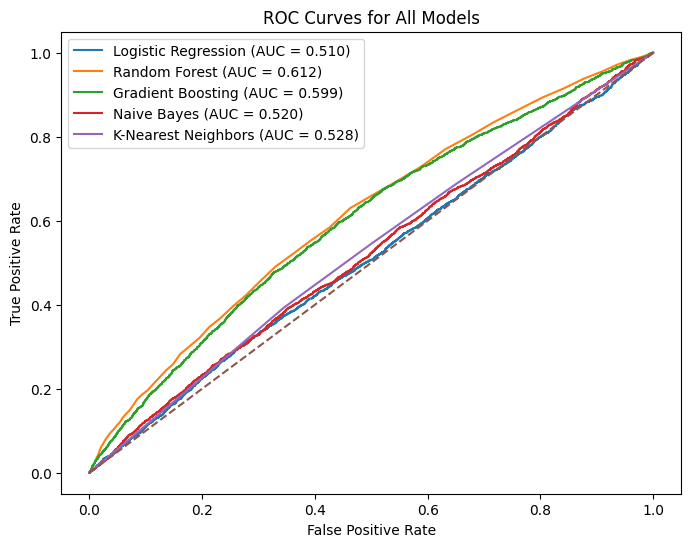

In [ ]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    pipe = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)

    y_prob = pipe.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.show()


In [ ]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [ ]:
def evaluate_model(model, X, y):
    pipe = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    scores = cross_val_score(
        pipe,
        X,
        y,
        cv=cv,
        scoring='roc_auc'
    )

    return scores.mean(), scores.std()

In [ ]:
for name, model in models.items():
    mean_auc, std_auc = evaluate_model(model, X, y)
    print(f"{name}: ROC-AUC = {mean_auc:.3f} ± {std_auc:.3f}")


Logistic Regression: ROC-AUC = 0.514 ± 0.006
Random Forest: ROC-AUC = 0.606 ± 0.005
Gradient Boosting: ROC-AUC = 0.593 ± 0.008
Naive Bayes: ROC-AUC = 0.516 ± 0.004
K-Nearest Neighbors: ROC-AUC = 0.516 ± 0.004


so,Random Forest is the best model among all five models.

In [ ]:
depths = [4, 6, 8, 10, None]

for d in depths:
    rf = RandomForestClassifier(
        max_depth=d,
        random_state=42,
        class_weight='balanced'
    )

    mean_auc, _ = evaluate_model(rf, X, y)
    print(f"max_depth={d}: ROC-AUC={mean_auc:.3f}")


max_depth=4: ROC-AUC=0.560
max_depth=6: ROC-AUC=0.567
max_depth=8: ROC-AUC=0.572
max_depth=10: ROC-AUC=0.579
max_depth=None: ROC-AUC=0.606


In [ ]:
leaf_sizes = [1, 10, 30, 50, 100]

for leaf in leaf_sizes:
    rf = RandomForestClassifier(
        max_depth=10,
        min_samples_leaf=leaf,
        random_state=42,
        class_weight='balanced'
    )

    mean_auc, _ = evaluate_model(rf, X, y)
    print(f"min_samples_leaf={leaf}: ROC-AUC={mean_auc:.3f}")


min_samples_leaf=1: ROC-AUC=0.579
min_samples_leaf=10: ROC-AUC=0.580
min_samples_leaf=30: ROC-AUC=0.578
min_samples_leaf=50: ROC-AUC=0.577
min_samples_leaf=100: ROC-AUC=0.576


In [ ]:
n_trees = [100, 200, 300, 500]

for n in n_trees:
    rf = RandomForestClassifier(
        max_depth=10,
        min_samples_leaf=10,
        n_estimators=n,
        random_state=42,
        class_weight='balanced'
    )

    mean_auc, _ = evaluate_model(rf, X, y)
    print(f"n_estimators={n}: ROC-AUC={mean_auc:.3f}")

n_estimators=100: ROC-AUC=0.580
n_estimators=200: ROC-AUC=0.580
n_estimators=300: ROC-AUC=0.579
n_estimators=500: ROC-AUC=0.579


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=123
)

In [ ]:
final_model = Pipeline([
    ('smote', SMOTE(random_state=123)),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=123
    ))
])

final_model.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=10,
                                        random_state=123))])

In [ ]:
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:,1]
y_pred_custom = (y_prob > 0.3).astype(int)

print(classification_report(y_test, y_pred_custom))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.91      0.52      0.66     22603
           1       0.14      0.60      0.22      2839

    accuracy                           0.53     25442
   macro avg       0.52      0.56      0.44     25442
weighted avg       0.83      0.53      0.61     25442

ROC-AUC: 0.5804414551447838


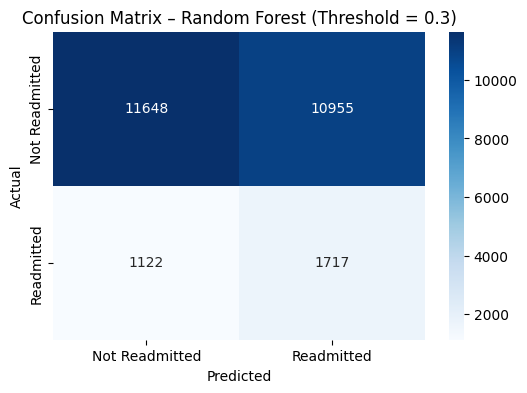

In [ ]:
from sklearn.metrics import confusion_matrix

cm_matrix = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Readmitted', 'Readmitted'],
    yticklabels=['Not Readmitted', 'Readmitted']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Random Forest (Threshold = 0.3)')
plt.show()

In [ ]:
import pandas as pd

# Access the fitted RandomForestClassifier from the final_model pipeline
fitted_rf_model = final_model.named_steps['rf']

imp = pd.Series(fitted_rf_model.feature_importances_, index=X.columns)
imp.sort_values(ascending=False).head(10)

,0
insulin_No,0.114663
insulin_Steady,0.093074
age,0.067612
change_No,0.064649
metformin_Steady,0.059376
admission_source_id,0.054286
gender_Male,0.054119
diabetesMed_Yes,0.050361
discharge_disposition_id,0.042032
insulin_Up,0.038316
